In [0]:

%matplotlib inline
import nengo
from nengo.dists import Uniform
from nengo.utils.ensemble import response_curves
import numpy as np
import matplotlib.pyplot as plt





[[42, 10, 30, 51, [0, 1]], [118, 128, 154, 151, [1, 0]], [30, 51, 37, 62, [0, 1]], [154, 151, 128, 115, [1, 0]], [37, 62, 43, 77, [0, 1]], [128, 115, 110, 141, [1, 0]], [43, 77, 27, 98, [0, 1]], [110, 141, 180, 156, [1, 0]], [27, 98, 67, 38, [0, 1]], [180, 156, 138, 180, [1, 0]], [67, 38, 38, 46, [0, 1]], [138, 180, 174, 175, [1, 0]], [38, 46, 77, 35, [0, 1]], [174, 175, 144, 137, [1, 0]], [77, 35, 69, 38, [0, 1]], [144, 137, 131, 100, [1, 0]], [69, 38, 40, 15, [0, 1]], [131, 100, 193, 112, [1, 0]], [40, 15, 41, 95, [0, 1]], [193, 112, 130, 153, [1, 0]], [41, 95, 98, 34, [0, 1]], [130, 153, 170, 165, [1, 0]], [98, 34, 50, 5, [0, 1]], [170, 165, 129, 130, [1, 0]], [50, 5, 61, 57, [0, 1]], [129, 130, 117, 170, [1, 0]], [61, 57, 89, 47, [0, 1]], [117, 170, 165, 146, [1, 0]], [89, 47, 20, 77, [0, 1]], [165, 146, 110, 109, [1, 0]], [20, 77, 63, 17, [0, 1]], [110, 109, 141, 120, [1, 0]], [63, 17, 75, 74, [0, 1]], [141, 120, 179, 190, [1, 0]], [75, 74, 18, 69, [0, 1]], [179, 190, 175, 110, [1

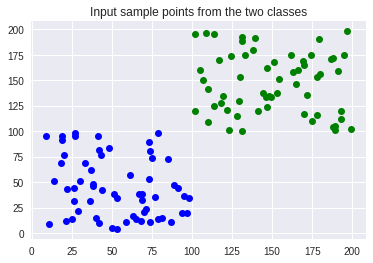

In [0]:
def generateData(n):
    """ 
    generates a 2D dataset with n samples. 
    The third element of the sample is the label
    """
    xb = np.random.randint(4,100,[n])
    yb = np.random.randint(4,100,[n])
    xg = np.random.randint(100,200,[n])
    yg = np.random.randint(100,200,[n])
    
    inputs = []
    for i in range(len(xb)):
      
      try:
        inputs.append([xb[i],yb[i],xb[i+1],yb[i+1],[0,1]])
        inputs.append([xg[i],yg[i],xg[i+1],yg[i+1],[1,0]])
      except Exception:
        pass
    print(inputs)
    return inputs


samples = 60
data = generateData(samples)
plt.figure()
plt.title("Input sample points from the two classes")
for x in data:
    if x[4][0] == 1:
        plt.plot(x[0], x[1], 'og')
    elif x[4][1] == 1:
        plt.plot(x[0], x[1], 'ob')
    else:
        plt.plot(x[0], x[1], 'om')

In [0]:
N = 100 #number of neurons
D_inp = 2
D_out = 2
factor = 11.0/12.0
sim_time = samples
model = nengo.Network('2-class Classification')
weights = np.random.randn(D_inp,D_out).transpose()  

with model:  
    
    def stim(t):
        for i in range(samples):
            if int(t) % samples <= i:
                return [data[i][0], data[i][1]]
        return 0
    
        
    def stim_ans(t):
        for i in range(samples):
            if int(t) % samples <= i:
                return data[i][2]
        return 0   
    
    
    #Define network inputs
    stim = nengo.Node(output=stim, size_out=D_inp)
    stim_ans = nengo.Node(output=stim_ans, size_out=D_out)
    
    #Create neural ensembles
    input = nengo.Ensemble(N*D_inp, dimensions=D_inp, label="input") 
    answer = nengo.Ensemble(N*D_out, dimensions=D_out, label="answer")
    correct_answer = nengo.Ensemble(N*D_out, dimensions=D_out, radius=2, label="correct_answer") 
    
    
    #Provide inputs to the network
    nengo.Connection(stim, input) 
    nengo.Connection(stim_ans, correct_answer)
    
    #Compute error for learning which gets inhibited
    error = nengo.Ensemble(N*D_out, dimensions=D_out, radius=2, label="error")  
    nengo.Connection(answer, error, transform=1)
    nengo.Connection(correct_answer, error, transform=-1)
    
    #Compute the actual error
    actual_error = nengo.Ensemble(N*D_out, dimensions=D_out, label="actual_error")
    nengo.Connection(answer, actual_error, transform=1)
    nengo.Connection(correct_answer, actual_error, transform=-1)
    
    #Specify the learning rule and the weight solver
    conn = nengo.Connection(input, answer, transform=weights, solver=nengo.solvers.LstsqL2(weights=True)) 
    conn.learning_rule_type={'my_pes': nengo.PES(learning_rate = 1e-4  )}
#     conn.learning_rule_type['my_pes'].
    
    #Provide error for learning
    error_conn = nengo.Connection(error, conn.learning_rule['my_pes'])    

    #Inhibit learning after the training period
    def inhibit(t):
        return 2.0 if t > int(factor*samples) else 0.0
     
    inhib = nengo.Node(inhibit)
    nengo.Connection(inhib, error.neurons, transform=[[-1]] * error.n_neurons)

In [0]:
with model:
    input_p = nengo.Probe(input, synapse=0.1)
    answer_p = nengo.Probe(answer, synapse=0.1)
    correct_answer_p = nengo.Probe(correct_answer, synapse=0.1)
    error_p = nengo.Probe(error, synapse=0.1)   
    actual_error = nengo.Probe(actual_error, synapse=0.1)

In [0]:
sim = nengo.Simulator(model)
sim.run(sim_time)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

predicted 0 correct 0
predicted 0 correct 0
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 0
predicted 1 correct 0
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 1 correct 1
predicted 

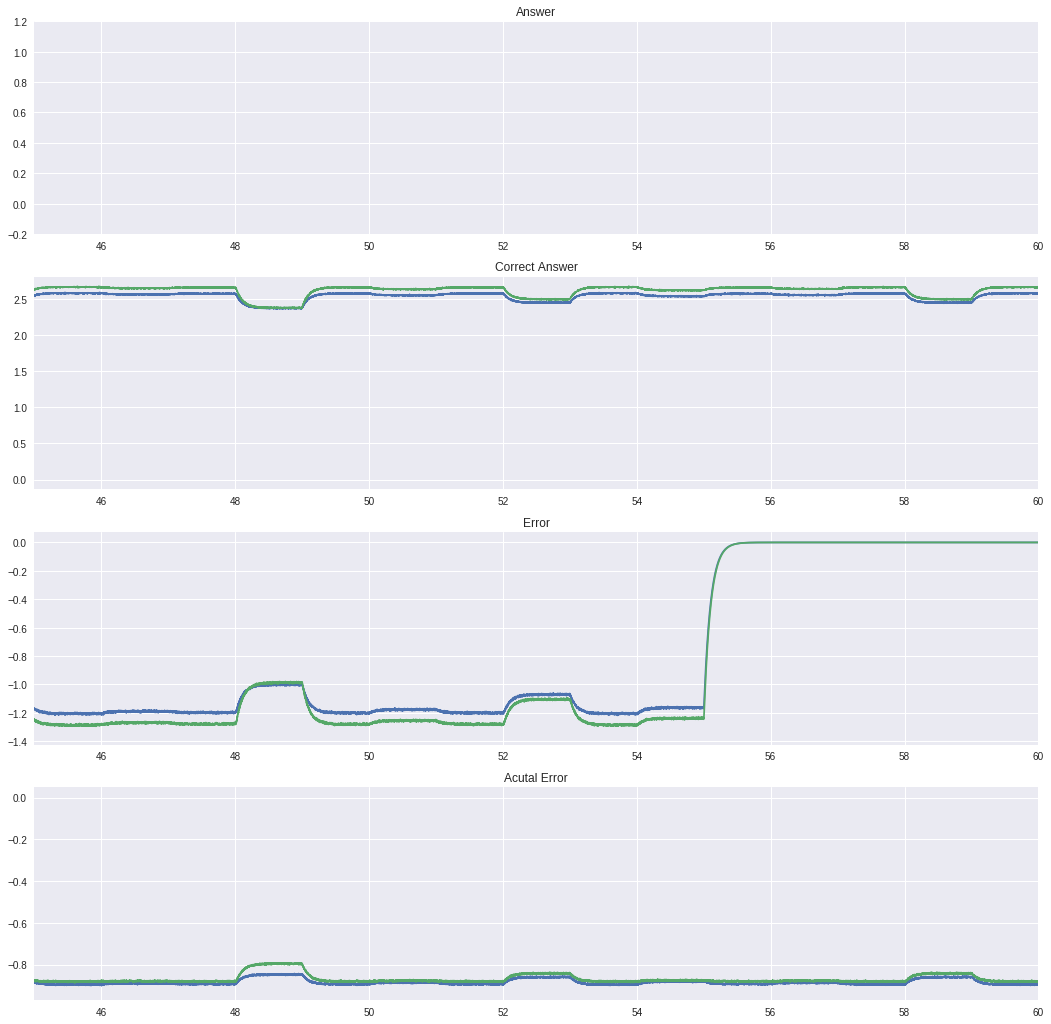

In [0]:
fig = plt.figure(figsize=(18,18))
p1 = fig.add_subplot(4,1,1)
p1.plot(t, sim.data[answer_p])
p1.set_title("Answer")
p1.set_xlim(int(factor*samples)-10,sim_time)
p1.set_ylim(-0.2,1.2)

p2 = fig.add_subplot(4,1,2)
p2.plot(t, sim.data[correct_answer_p])
p2.set_title("Correct Answer")
p2.set_xlim(int(factor*samples)-10,sim_time)

p3 = fig.add_subplot(4,1,3)
p3.plot(t, sim.data[error_p])
p3.set_title("Error")
p3.set_xlim(int(factor*samples)-10,sim_time)

p4 = fig.add_subplot(4,1,4)
p4.plot(t, sim.data[actual_error])
p4.set_title("Acutal Error")
p4.set_xlim(int(factor*samples)-10,sim_time)


for i in zip(sim.data[answer_p].tolist()[:50],sim.data[correct_answer_p].tolist()[:50]):
  first=i[0]
  second = i[1]
  print("predicted {} correct {}".format(first.index(max(first)),second.index(max(second))))
